<a href="https://colab.research.google.com/github/MANOJ-S-NEGI/SKIM_LIT_NPL/blob/main/skim_literature_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

DATA_SOURCE: https://github.com/Franck-Dernoncourt/pubmed-rct.git

## DATA PROCESSING

In [ ]:
# defining the function to read the lines of a docuents:

def get_lines(filenames):
    with open(filenames, "r") as f:
        return f.readlines()


In [ ]:
# setting path and readind the txt files:
train_path = "/content/train.txt"
test_path = "/content/test.txt"
dev_path = "/content/dev.txt"
train_lines = get_lines(train_path)
train_lines[:20]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [ ]:
# checking lines  better visuals:
for i in train_lines[:5]:
    print(i)


###24491034

BACKGROUND	The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .

BACKGROUND	This paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .

METHODS	This study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .

METHODS	The intervention group will participate in the online group program ` Positive Outlook ' .



In [ ]:
class PreprocessTextWithLineNumbers:
    def __init__(self, path):
        self.path = path

    def path_fetch_and_separation(self):
        try:
            abstract_data = []
            with open(self.path, 'r') as file:
                for line in file:
                    if not line.startswith("###"):
                        abstract_data.append(line.strip())
            return abstract_data

        except Exception as e:
            print(f"An unexpected error occurred: {e}")

    def process_data_into_dict(self):
        try:
            abstract_sample = []
            for abstract_line_number, abstract_line in enumerate(self.path_fetch_and_separation()):
                line_data = {}
                target_text_split = abstract_line.split("\t")

                if len(target_text_split) > 1:
                    line_data["target"] = target_text_split[0]
                    line_data["text"] = target_text_split[1].lower()
                    line_data["line_number"] = abstract_line_number
                    #line_data["total_lines"] = len(abstract_line_split) - 1
                    abstract_sample.append(line_data)

            return abstract_sample

        except Exception as e:
            print(f"An unexpected error occurred: {e}")

def processed_file(path):
    preprocess_data = PreprocessTextWithLineNumbers(path)
    return preprocess_data.process_data_into_dict()


In [ ]:
train_data = processed_file(train_path)
test_data = processed_file(test_path)
dev_data = processed_file(dev_path)

In [ ]:
# putting train_data into dataframe:
import pandas as pd
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
val_data = pd.DataFrame(dev_data)
train_data.sample(10)

,target,text
4674,CONCLUSIONS,low-dose mitomycin c may be useful in standard...
3145,METHODS,sixty participants ( @ hands ) with oa of the ...
2201,METHODS,clinical and radiograph evaluation were perfor...
196,RESULTS,no difference was found between the groups reg...
584,CONCLUSIONS,no significant long-term advantage in psychoso...
3328,RESULTS,all coaches except @ ( @ % ) intended to conti...
3086,CONCLUSIONS,ct performed in the same weekly frequency and ...
2056,BACKGROUND,sustained hypotension after an acute dynamic e...
2852,METHODS,the secondary end point was the concordance ra...
913,CONCLUSIONS,xyk has significant therapeutic effect in trea...


In [ ]:
# Distribution of labels in training data
train_data.target.value_counts()


RESULTS        2280
METHODS        2176
CONCLUSIONS    1023
BACKGROUND      582
OBJECTIVE       519
Name: target, dtype: int64

Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_data["text"].tolist()
test_sentences = test_data["text"].tolist()
val_sentences = val_data["text"].tolist()

In [ ]:
# checking length
len(train_sentences), len(val_sentences), len(test_sentences)

(6580, 6536, 6575)

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_data["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_data["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_data["target"].to_numpy())

In [ ]:
train_labels_encoded

array([0, 0, 2, ..., 2, 4, 4])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

**Model 0: Getting a baseline**

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# importing from sklearn library
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
# creating pipeline:

model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
                ])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded);


In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.6459608323133414

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 4, 4, ..., 2, 4, 4])

In [ ]:
model_0_result = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

model_0_result

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 64.59608323133415,
 'precision': 0.5954490610692178,
 'recall': 0.6459608323133414,
 'f1': 0.5819085876230404}

---
---
Create text vectorizer

In [ ]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, output_sequence_length=55)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),

Number of words in vocabulary: 10789


(None,)

In [ ]:

# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the combination of larger trials required to provide definitive answers on the impact that postoperative radiotherapy will have on survival .

Length of text: 21

Vectorized text:
[[   2  231    3  993  299  436    6  869 3228 3307   18    2  391   30
   159  441  321  113   18  191    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 10789}

**Create custom text embedding**

In [ ]:
# Create token embedding layer:
from tensorflow.keras import layers

token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),
                               output_dim = 128,
                               mask_zero = True,
                               name = "token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
the combination of larger trials required to provide definitive answers on the impact that postoperative radiotherapy will have on survival .

Sentence after vectorization (before embedding):
[[   2  231    3  993  299  436    6  869 3228 3307   18    2  391   30
   159  441  321  113   18  191    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.01968236  0.04939333 -0.01459261 ...  0.00777439 -0.02695487
    0.04907003]
  [ 0.02678419  0.01008222  0.01615481 ...  0.04167253 -0.01649108
    0.04353036]
  [-0.03263947  0.03802695  0.02836544 ...  0.04521065  0.00173528
   -0.00300187]
  ...
  [ 0.01225883  0.00700734 -0.01818819 ...  0.04828379  0.01119556
    0.0087638 ]
  [ 0.01225883  0.00700734 -0.01818819 ...  0.04828379  0.01119556
    0.0087638 ]
  [ 0.01225883  0.00700734 -0.01818819 ...  

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(sparse_output = False)
train_labels_one_hot = OHE.fit_transform(train_data["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = OHE.transform(val_data["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = OHE.transform(test_data["target"].to_numpy().reshape(-1, 1))

# sample of train_labels_one_hot:
train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
# Turn our data into TensorFlow Datasets
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

**Model 1: Conv1D with token embeddings**

In [ ]:
# Create 1D convolutional model to process sequences
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
text_vector = text_vectorizer(inputs)
token_embeddings = token_embed(text_vector) # create embedding
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation= "relu")(token_embeddings)

x = tf.keras.layers.Conv1D(64,3, activation= "relu")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)


# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Get summary of Conv1D model
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 token_embedding (Embedding  (None, 55, 128)           1380992   
 )                                                               
                                                                 
 conv1d_10 (Conv1D)          (None, 55, 64)            41024     
                                                                 
 conv1d_11 (Conv1D)          (None, 53, 64)            12352     
                                                                 
 global_average_pooling1d_7  (None, 64)                0   

In [ ]:
# Fit model
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=3,               # Number of epochs with no improvement after which training will be stopped
    verbose=1,               # Display log messages
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)


# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=20,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)), # only validate on 10% of batches
                              callbacks = [early_stop])


Epoch 1/20
20/20 [==============================] - 4s 162ms/step - loss: 1.4109 - accuracy: 0.4000 - val_loss: 1.1773 - val_accuracy: 0.5750
Epoch 2/20
20/20 [==============================] - 4s 203ms/step - loss: 0.9902 - accuracy: 0.6313 - val_loss: 0.8723 - val_accuracy: 0.6922
Epoch 3/20
20/20 [==============================] - 2s 116ms/step - loss: 0.6511 - accuracy: 0.7625 - val_loss: 0.7567 - val_accuracy: 0.7016
Epoch 4/20
20/20 [==============================] - 1s 54ms/step - loss: 0.5022 - accuracy: 0.8250 - val_loss: 0.7201 - val_accuracy: 0.7188
Epoch 5/20
20/20 [==============================] - 1s 59ms/step - loss: 0.4623 - accuracy: 0.8000 - val_loss: 0.7149 - val_accuracy: 0.7266
Epoch 6/20
20/20 [==============================] - 1s 66ms/step - loss: 0.4339 - accuracy: 0.8422 - val_loss: 0.7424 - val_accuracy: 0.7297
Epoch 7/20
20/20 [==============================] - 1s 37ms/step - loss: 0.4161 - accuracy: 0.8266 - val_loss: 0.7231 - val_accuracy: 0.7344
Epoch 8/20

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs


205/205 [==============================] - 1s 4ms/step


array([[4.6115461e-01, 3.1202278e-01, 1.3309208e-05, 2.2680518e-01,
        4.0974978e-06],
       [4.9477466e-04, 3.5672172e-04, 9.6054596e-01, 1.0926245e-03,
        3.7510041e-02],
       [7.6241052e-04, 3.0227458e-02, 1.2059624e-02, 4.9235555e-04,
        9.5645821e-01],
       ...,
       [5.2287905e-03, 2.3350157e-03, 9.3015248e-01, 7.9655135e-03,
        5.4318227e-02],
       [4.7497591e-03, 5.2776434e-02, 1.7316021e-02, 2.5896661e-03,
        9.2256808e-01],
       [3.4693943e-03, 4.5789522e-03, 6.2492472e-01, 3.6900775e-03,
        3.6333686e-01]], dtype=float32)

In [ ]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

205/205 [==============================] - 2s 9ms/step - loss: 0.7245 - accuracy: 0.7370


[0.7244678735733032, 0.7369951009750366]

In [ ]:

# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds


<tf.Tensor: shape=(6536,), dtype=int64, numpy=array([0, 2, 4, ..., 2, 4, 2])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 73.69951040391676,
 'precision': 0.7298198089752317,
 'recall': 0.7369951040391677,
 'f1': 0.7305875582918205}

---
---
**Model 2: Feature extraction with pretrained token embeddings**

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

#### sample testing

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
to assess differences through grade @ in diet , physical activity , and related health indicators of students who participated in the child and adolescent trial for cardiovascular health ( catch ) school and family intervention from grades @ through @ .

Sentence after embedding:
[-0.03698356  0.03442623 -0.01762473 -0.01802581 -0.07385452 -0.03297535
 -0.00124993  0.03804636 -0.00965928  0.04716054  0.07754634 -0.03764406
  0.04004035 -0.03869425 -0.047147    0.0169241  -0.08725169  0.07658144
 -0.00681534 -0.08713003  0.07382903  0.01380375  0.00697132 -0.06589474
  0.00990501 -0.00160036 -0.0577521   0.08055027 -0.01660048  0.00840545] (truncated output)...

Length of sentence embedding:
512


In [ ]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding

outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit feature extractor model for 20 epochs

model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=20,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)), # only validate on 10% of batches
                              callbacks = [early_stop])


Epoch 1/20
20/20 [==============================] - 4s 170ms/step - loss: 1.5170 - accuracy: 0.4234 - val_loss: 1.4020 - val_accuracy: 0.5250
Epoch 2/20
20/20 [==============================] - 2s 115ms/step - loss: 1.3381 - accuracy: 0.4969 - val_loss: 1.2382 - val_accuracy: 0.5562
Epoch 3/20
20/20 [==============================] - 2s 83ms/step - loss: 1.1767 - accuracy: 0.5719 - val_loss: 1.1124 - val_accuracy: 0.6141
Epoch 4/20
20/20 [==============================] - 2s 82ms/step - loss: 1.0521 - accuracy: 0.6078 - val_loss: 1.0197 - val_accuracy: 0.6297
Epoch 5/20
20/20 [==============================] - 2s 83ms/step - loss: 1.0031 - accuracy: 0.6109 - val_loss: 0.9457 - val_accuracy: 0.6547
Epoch 6/20
20/20 [==============================] - 2s 82ms/step - loss: 0.8947 - accuracy: 0.6562 - val_loss: 0.8929 - val_accuracy: 0.6687
Epoch 7/20
20/20 [==============================] - 2s 84ms/step - loss: 0.8577 - accuracy: 0.6797 - val_loss: 0.8532 - val_accuracy: 0.6766
Epoch 8/20


20/20 [==============================] - 1s 76ms/step - loss: 0.8345 - accuracy: 0.7167 - val_loss: 0.8042 - val_accuracy: 0.7063


---
---
### Model 3: Conv1D with character embeddings:

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))


# Test splitting non-character-level sequence into characters
split_chars(train_sentences[:2])

'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments . this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .'

In [ ]:
# Split sequence-level data splits into character-level data splits

def chars(data):
    try:
        all_split_word = []
        for i in data:
            split_words = split_chars(i)
            all_split_word.append(split_words)
        return all_split_word

    except Exception as e:
        raise e


In [ ]:
train_chars = chars(train_sentences)
val_chars = chars(val_sentences)
test_chars = chars(test_sentences)

In [ ]:
train_chars[0]


't h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .'

In [ ]:
import numpy as np
lengths = []
for i in train_sentences:
    length = len(i)
    lengths.append(length)

mean_char_len = np.mean(lengths)
print(mean_char_len)

148.19954407294833


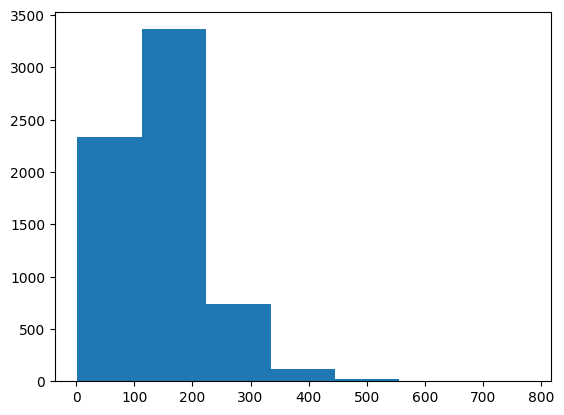

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(lengths, 95))
output_seq_char_len

287

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
print(alphabet)

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
NUM_CHAR_TOKENS

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


70

In [ ]:
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")


Number of different characters in character vocab: 28


In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKENS, # number of different characters
                              output_dim = 28, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

In [ ]:
# Test out character embedding layer
sample_text = random.choice(train_chars)
print(f"Charified text (before vectorization and embedding):\n{sample_text}\n")
char_embed_example = char_embed(char_vectorizer(sample_text))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")


Charified text (before vectorization and embedding):
i n c i d e n c e   a n d   s e v e r i t y   o f   a d v e r s e   e v e n t s   (   a e s   )   w e r e   r e p o r t e d   .

Embedded chars (after vectorization and embedding):
[[ 0.0023666   0.03168596 -0.0275244  ...  0.04326541  0.00485951
  -0.00983476]
 [ 0.0199982   0.00296701 -0.02999954 ...  0.01116987  0.01640866
  -0.01433099]
 [-0.03821148  0.02413832 -0.03645932 ... -0.04653449 -0.03774378
   0.00088005]
 ...
 [ 0.04171406  0.03730826  0.01223714 ... -0.01488291  0.03549669
  -0.02475061]
 [ 0.04171406  0.03730826  0.01223714 ... -0.01488291  0.03549669
  -0.02475061]
 [ 0.04171406  0.03730826  0.01223714 ... -0.01488291  0.03549669
  -0.02475061]]

Character embedding shape: (287, 28)


**Building a Conv1D model to fit on character embeddings**


In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x =  layers.LSTM(128, return_sequences=True)(char_embeddings)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(64)(x)



outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_3.summary()


Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 287)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 287, 28)           1960      
                                                                 
 lstm_1 (LSTM)               (None, 287, 128)          80384     
                                                                 
 dropout (Dropout)           (None, 287, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                     

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=20,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)),
                              callbacks = [early_stop])

Epoch 1/20
20/20 [==============================] - 8s 93ms/step - loss: 1.5057 - accuracy: 0.2891 - val_loss: 1.4528 - val_accuracy: 0.3500
Epoch 2/20
20/20 [==============================] - 1s 36ms/step - loss: 1.4716 - accuracy: 0.3094 - val_loss: 1.4609 - val_accuracy: 0.3359
Epoch 3/20
20/20 [==============================] - 1s 48ms/step - loss: 1.4407 - accuracy: 0.3234 - val_loss: 1.4389 - val_accuracy: 0.3500
Epoch 4/20
20/20 [==============================] - 1s 48ms/step - loss: 1.4168 - accuracy: 0.3531 - val_loss: 1.4466 - val_accuracy: 0.3359
Epoch 4: early stopping


## **Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)**

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)


# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(64))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf

char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)


# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.3)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.2)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


# Get summary of token and character model
model_4.summary()



Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 287)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

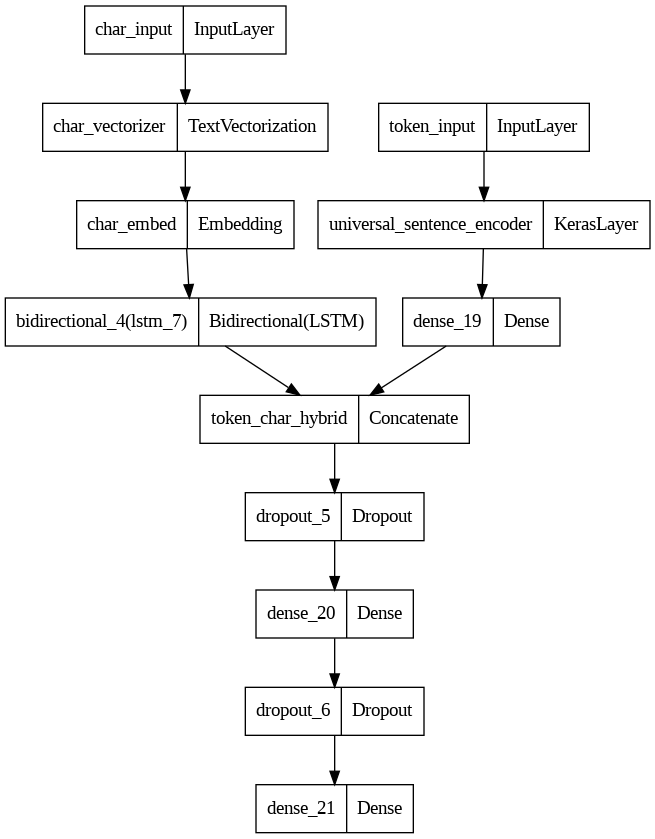

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)


In [ ]:

# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])


In [ ]:

# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=30,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)),
                              callbacks=[early_stop])


Epoch 1/30
20/20 [==============================] - 13s 243ms/step - loss: 1.4401 - accuracy: 0.3828 - val_loss: 1.3601 - val_accuracy: 0.4688
Epoch 2/30
20/20 [==============================] - 3s 145ms/step - loss: 1.3272 - accuracy: 0.4641 - val_loss: 1.1978 - val_accuracy: 0.5297
Epoch 3/30
20/20 [==============================] - 2s 109ms/step - loss: 1.1024 - accuracy: 0.5625 - val_loss: 1.0005 - val_accuracy: 0.6016
Epoch 4/30
20/20 [==============================] - 2s 121ms/step - loss: 0.9373 - accuracy: 0.6406 - val_loss: 0.8867 - val_accuracy: 0.6531
Epoch 5/30
20/20 [==============================] - 2s 106ms/step - loss: 0.9179 - accuracy: 0.6344 - val_loss: 0.8473 - val_accuracy: 0.7016
Epoch 6/30
20/20 [==============================] - 1s 47ms/step - loss: 0.8272 - accuracy: 0.6781 - val_loss: 0.7965 - val_accuracy: 0.7000
Epoch 7/30
20/20 [==============================] - 2s 129ms/step - loss: 0.7861 - accuracy: 0.6797 - val_loss: 0.7734 - val_accuracy: 0.7047
Epoch 

20/20 [==============================] - 2s 103ms/step - loss: 0.8121 - accuracy: 0.7222 - val_loss: 0.7472 - val_accuracy: 0.7219


**Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings**

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

205/205 [==============================] - 10s 39ms/step


array([[0.11145966, 0.18440787, 0.55202216, 0.0367606 , 0.11534975],
       [0.02687646, 0.03015383, 0.80326223, 0.02683708, 0.11287044],
       [0.00387866, 0.03058546, 0.15135807, 0.0008291 , 0.8133487 ],
       ...,
       [0.11835781, 0.18136412, 0.35097626, 0.1974243 , 0.15187751],
       [0.01025469, 0.01926782, 0.73383623, 0.01098277, 0.2256585 ],
       [0.00611552, 0.01467473, 0.55149025, 0.00408933, 0.42363015]],
      dtype=float32)

In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

205/205 [==============================] - 7s 36ms/step - loss: 0.7636 - accuracy: 0.7067


[0.7636170387268066, 0.7067013382911682]

In [ ]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(6536,), dtype=int64, numpy=array([2, 2, 4, ..., 2, 2, 2])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 70.67013463892289,
 'precision': 0.7004037969154118,
 'recall': 0.7067013463892289,
 'f1': 0.6834473463583138}